In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    
    accuracy = accuracy_score(y_test, pred)
    
    precision = precision_score(y_test, pred, pos_label=1)
    recall = recall_score(y_test, pred, pos_label=1)
    f1 = f1_score(y_test, pred, pos_label=1)
    
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('오차 행렬')
    print(confusion)
    
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [2]:
RANDOM_STATE = 11

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_df = pd.read_csv('./titanic/titanic_train.csv')
predict_df = pd.read_csv('./titanic/test.csv')
gender_submission_df = pd.read_csv('./titanic/gender_submission.csv')


# First Name
train_df['Title'] = train_df.Name.str.extract(r'([A-Za-z]+)\.', expand=False)
predict_df['Title'] = predict_df.Name.str.extract(r'([A-Za-z]+)\.', expand=False)
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', \
                                                         'Dona'], 'Rare')
train_df['Title'] = train_df['Title'].replace(['Mlle'], 'Miss')
train_df['Title'] = train_df['Title'].replace(['Ms'], 'Miss')
train_df['Title'] = train_df['Title'].replace(['Mme'], 'Mrs')

predict_df['Title'] = predict_df['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', \
                                                         'Dona'], 'Rare')
predict_df['Title'] = predict_df['Title'].replace(['Mlle'], 'Miss')
predict_df['Title'] = predict_df['Title'].replace(['Ms'], 'Miss')
predict_df['Title'] = predict_df['Title'].replace(['Mme'], 'Mrs')


# Age
average_pclass = train_df.groupby('Pclass')['Age'].mean()
# train_df['Age'] = train_df.apply(lambda row: average_pclass[row['Pclass']] if pd.isna(row['Age']) else row['Age'], axis=1)
# predict_df['Age'] = predict_df.apply(lambda row: average_pclass[row['Pclass']] if pd.isna(row['Age']) else row['Age'], axis=1)
train_df['Age'].fillna(train_df.groupby('Title')['Age'].transform('median'), inplace=True)
predict_df['Age'].fillna(predict_df.groupby('Title')['Age'].transform('median'), inplace=True)


def get_category(age):
    cat = ''
    if age <= -1: cat = 'Unknown'
    elif age <= 8: cat = 'Baby'
    elif age <= 13: cat = 'Child'
    elif age <= 19: cat = 'Teenager'
    elif age <= 26: cat = 'Student'
    elif age <= 39: cat = 'Young Adult'
    elif age <= 64: cat = 'Adult'
    else: cat = 'Elderly'        
    return cat

group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']
 
train_df['Age_range'] = train_df['Age'].apply(lambda x : get_category(x))
predict_df['Age_range'] = predict_df['Age'].apply(lambda x : get_category(x))


# Fare
def get_category(fare):
    cat = ''
    if fare >= 30: cat = 1
    elif fare >= 12: cat = 2
    else: cat = 3
    return cat

group_names = [1, 2, 3]
 
train_df['Fare_range'] = train_df['Fare'].apply(lambda x : get_category(x))
predict_df['Fare_range'] = predict_df['Fare'].apply(lambda x : get_category(x))

# Fare Bend -> data Binning
train_df['Fare_Bend'] = pd.qcut(train_df['Fare'], 5, labels=[0,1,2,3,4])
# train_df.groupby('Fare_Band', as_index=False)['Survived'].mean().sort_values(by='Fare_Band', ascending=True)

predict_df['Fare'].fillna(predict_df['Fare'].dropna().median(), inplace=True) # NaN 값을 median 값으로 대체한 후 train_data와 마찬가지로 분류
predict_df.loc[(predict_df["Fare"] <= 7.854), "Fare_Band"] = 0
predict_df.loc[(predict_df["Fare"] > 7.854) & (predict_df["Fare"] <= 10.500), "Fare_Band"] = 1
predict_df.loc[(predict_df["Fare"] > 10.5) & (predict_df["Fare"] <= 21.679), "Fare_Band"] = 2
predict_df.loc[(predict_df["Fare"] > 21.679) & (predict_df["Fare"] <= 39.688), "Fare_Band"] = 3
predict_df.loc[(predict_df["Fare"] > 39.688), "Fare_Band"] = 4


# pclass, sex, age_range merge
# plcass_sex = [
#     # 'Pclass', 'Sex', 'Age_range'] -> Age_range를 추가했을 때 label encoding에서 오류가 발생해 Age_range는 제거하고 진행
#     'Pclass', 'Sex']
# print(plcass_sex, '\n')

# train_df['plcass_sex'] = train_df[plcass_sex].apply(lambda x: '_'.join(x.astype(str)), axis=1)
# predict_df['plcass_sex'] = predict_df[plcass_sex].apply(lambda x: '_'.join(x.astype(str)), axis=1)

# plcass_sex_to_drop = ['Pclass', 'Sex']
# train_df = train_df.drop(columns=[col for col in plcass_sex_to_drop if col in train_df.columns])
# predict_df = predict_df.drop(columns=[col for col in plcass_sex_to_drop if col in predict_df.columns])


# Embarked NaN 값 처리
train_df.loc[train_df['Embarked'].isna(), 'Embarked'] = 'C'


# Familly
train_df['Familly'] = train_df['SibSp'] + train_df['Parch'] + 1 # 1 = 자기 자신
predict_df['Familly'] = predict_df['SibSp'] + predict_df['Parch'] + 1
# train_df.groupby('Familly', as_index=False)['Survived'].mean().sort_values(by="Familly")

# 불필요한 특성, null 값 제거
def drop_features(df):
    df.drop(['PassengerId','Name', 'Ticket', 'Cabin', 'Fare', 'Fare_range', 'Fare_Bend', 'Familly'], axis=1, inplace=True)

    y = df['Survived']
    df = df.drop('Survived', axis=1, inplace=False)
    return df, y


X, y = drop_features(train_df)
feature = X.columns
predict_df = predict_df[feature]

/var/folders/7p/kq4ytf3n0rx3163p8dqq9x080000gn/T/ipykernel_59354/201761695.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(train_df.groupby('Title')['Age'].transform('median'), inplace=True)
/var/folders/7p/kq4ytf3n0rx3163p8dqq9x080000gn/T/ipykernel_59354/201761695.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate 

In [4]:
# train_df.groupby('Fare_Band', as_index=False)['Survived'].mean().sort_values(by='Fare_Band', ascending=True)

In [5]:
# train_df.groupby('Familly', as_index=False)['Survived'].mean().sort_values(by="Familly")

In [6]:
train_df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare'], dtype=object)

In [7]:
X

,Pclass,Sex,Age,SibSp,Parch,Embarked,Title,Age_range
0,3,male,22.0,1,0,S,Mr,Student
1,1,female,38.0,1,0,C,Mrs,Young Adult
2,3,female,26.0,0,0,S,Miss,Student
3,1,female,35.0,1,0,S,Mrs,Young Adult
4,3,male,35.0,0,0,S,Mr,Young Adult
...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,S,Rare,Young Adult
887,1,female,19.0,0,0,S,Miss,Teenager
888,3,female,21.0,1,2,S,Miss,Student
889,1,male,26.0,0,0,C,Mr,Student


In [8]:
X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'Title',
       'Age_range'],
      dtype='object')

In [9]:
# 라벨 인코딩 구현
from sklearn.preprocessing import LabelEncoder

# features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', 'Age_range']
features = ['Sex', 'Embarked', 'Age_range', 'Title']

le = LabelEncoder()
for i in features:
    encoder = LabelEncoder()
    encoder.fit(X[i])
    
    X[i] = encoder.transform(X[i])
    predict_df[i] = encoder.transform(predict_df[i])

In [10]:
print("train_df 데이터의 행 개수:", len(X))
print('train_df: 데이터 세트 Null 값 갯수 ',X.isnull().sum().sum())
print(X.isnull().sum())
print(X.columns)

train_df 데이터의 행 개수: 891
train_df: 데이터 세트 Null 값 갯수  0
Pclass       0
Sex          0
Age          0
SibSp        0
Parch        0
Embarked     0
Title        0
Age_range    0
dtype: int64
Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'Title',
       'Age_range'],
      dtype='object')


# 모든 feature 라벨인코딩 -> 스케일링 필요?

> -  순서가 없는 범주형 데이터에 적용하면 문제
> -  거리 기반 알고리즘이나 신경망을 사용할 경우 스케일링이 필요
> -  트리 기반 모델을 사용할 경우에는 필요하지 불필요

1. 거리 기반 알고리즘 (예: K-최근접 이웃(K-NN), K-평균 클러스터링)
    - 필요성: 매우 높음. 피처 간의 거리 계산에 라벨 인코딩된 값이 큰 영향을 줄 수 있으므로, 스케일링이 필요합니다.
2. 선형 모델 (예: 로지스틱 회귀, 선형 회귀)
    - 필요성: 보통 높음. 라벨 인코딩된 값이 모델의 가중치 추정에 영향을 미칠 수 있으므로, 스케일링이 유리할 수 있습니다.
3. 트리 기반 모델 (예: 결정 트리, 랜덤 포레스트, 그라디언트 부스팅)
    - 필요성: 낮음. 트리 기반 모델은 피처의 스케일에 크게 영향을 받지 않으므로, 스케일링이 필요하지 않습니다.
4. 신경망 (예: MLP, RNN, CNN)
    - 필요성: 높음. 신경망의 학습 과정에서 가중치 업데이트의 안정성을 위해 피처 스케일링이 중요합니다.

In [12]:
from sklearn.preprocessing import StandardScaler
# numerical_columns = ['Age']
numerical_columns = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Title', 'Age_range']

scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
predict_df[numerical_columns] = scaler.transform(predict_df[numerical_columns])

X = pd.DataFrame(X, columns=columns)
predict_df = pd.DataFrame(predict_df, columns=columns)

In [13]:
X

,Pclass,Sex,SibSp,Parch,Embarked,Title,Age_range
0,0.827377,0.737695,0.432793,-0.473674,0.589375,0.132454,0.000986
1,-1.566107,-1.355574,0.432793,-0.473674,-1.929248,1.401453,0.879868
2,0.827377,-1.355574,-0.474545,-0.473674,0.589375,-1.136545,0.000986
3,-1.566107,-1.355574,0.432793,-0.473674,0.589375,1.401453,0.879868
4,0.827377,0.737695,-0.474545,-0.473674,0.589375,0.132454,0.879868
...,...,...,...,...,...,...,...
886,-0.369365,0.737695,-0.474545,-0.473674,0.589375,2.670453,0.879868
887,-1.566107,-1.355574,-0.474545,-0.473674,0.589375,-1.136545,0.440427
888,0.827377,-1.355574,0.432793,2.008933,0.589375,-1.136545,0.000986
889,-1.566107,0.737695,-0.474545,-0.473674,-1.929248,0.132454,0.000986


In [18]:
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [17]:
predict_df

,Pclass,Sex,SibSp,Parch,Embarked,Title,Age_range
0,0.827377,0.737695,-0.474545,-0.473674,-0.669937,0.132454,0.879868
1,0.827377,-1.355574,0.432793,-0.473674,0.589375,1.401453,-1.756776
2,-0.369365,0.737695,-0.474545,-0.473674,-0.669937,0.132454,-1.756776
3,0.827377,0.737695,-0.474545,-0.473674,0.589375,0.132454,0.879868
4,0.827377,-1.355574,0.432793,0.767630,0.589375,1.401453,0.000986
...,...,...,...,...,...,...,...
413,0.827377,0.737695,-0.474545,-0.473674,0.589375,0.132454,0.879868
414,-1.566107,-1.355574,-0.474545,-0.473674,-1.929248,2.670453,0.879868
415,0.827377,0.737695,-0.474545,-0.473674,0.589375,0.132454,0.879868
416,0.827377,0.737695,-0.474545,-0.473674,0.589375,0.132454,0.879868


In [14]:
train_df.groupby(['Survived'])['Survived'].count()

Survived
0    549
1    342
Name: Survived, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

# lightGBM에서 사용
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=RANDOM_STATE)

# from imblearn.combine import SMOTETomek
# from imblearn.under_sampling import TomekLinks

# smoteto = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'), random_state=RANDOM_STATE)
# X_train, y_train = smoteto.fit_resample(X_train, y_train)

# print('피처 데이터 shape:{0}'.format(X_train.shape))
# print('피처 데이터 shape:{0}'.format(y_train.shape))

In [ ]:
stop

# RandomForest

In [ ]:
# max_depth, min_samples_split, min_samples_leaf, n_estimators

오차 행렬
[[364  20]
 [ 58 181]]
정확도: 0.8748, 정밀도: 0.9005, 재현율: 0.7573,    F1: 0.8227, AUC:0.9339
오차 행렬
[[146  19]
 [ 25  78]]
정확도: 0.8358, 정밀도: 0.8041, 재현율: 0.7573,    F1: 0.7800, AUC:0.8575


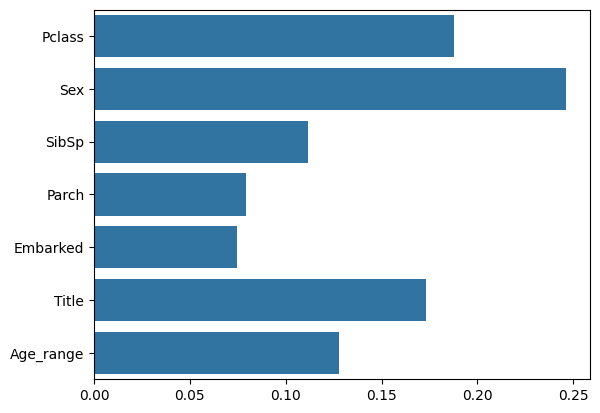

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)


# feature importance 추출 
feature_names = train_df.columns.drop('Survived')

# feature importance를 column 별로 시각화 하기 
sns.barplot(x=rf_clf.feature_importances_ , y=numerical_columns)


pred = rf_clf.predict(X_train) 
proba = rf_clf.predict_proba(X_train)[:, 1]

rf_pred = rf_clf.predict(X_test) 
rf_proba = rf_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_train, pred, proba)
get_clf_eval(y_test, rf_pred, rf_proba)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': np.arange(1, 10, 1),
    'min_samples_leaf' : np.arange(1, 40, 1),
    'min_samples_split' : np.arange(2, 40, 1)
}

rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, random_state=RANDOM_STATE)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

best_rf = grid_cv.best_estimator_

# feature importance 추출 
feature_names = train_df.columns.drop('Survived')

# feature importance를 column 별로 시각화 하기 
sns.barplot(x=best_rf.feature_importances_ , y=feature_names)

In [20]:
pred = best_rf.predict(X_train) 
proba = best_rf.predict_proba(X_train)[:, 1]

best_rf_pred = best_rf.predict(X_test) 
best_rf_proba = best_rf.predict_proba(X_test)[:, 1]

get_clf_eval(y_train, pred, proba)
get_clf_eval(y_test, best_rf_pred, best_rf_proba)

오차 행렬
[[364  20]
 [ 58 181]]
정확도: 0.8748, 정밀도: 0.9005, 재현율: 0.7573,    F1: 0.8227, AUC:0.9339
오차 행렬
[[146  19]
 [ 25  78]]
정확도: 0.8358, 정밀도: 0.8041, 재현율: 0.7573,    F1: 0.7800, AUC:0.8575


In [21]:
predict_titanic_pred_rf = rf_clf.predict(predict_df)

gender_submission_df['Survived'] = predict_titanic_pred_rf
gender_submission_df.to_csv('titanic_submission_rf.csv',index=False)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc = SVC(probability=True, random_state=RANDOM_STATE)
r=[0.0001,0.001,0.1,1,10,50,100]
PSVM = [{'C': r, 'kernel': ['linear']},
        {'C': r, 'gamma': r, 'kernel': ['rbf']}]

GSSVM=GridSearchCV(estimator=svc, param_grid=PSVM, scoring='accuracy', cv=2)
scores_svm=cross_val_score(GSSVM, X_train.astype(float), y_train,scoring='accuracy', cv=5)
GSSVM.fit(X_train, y_train)

In [ ]:
pred = GSSVM.predict(X_train) 
proba = GSSVM.predict_proba(X_train)[:, 1]

best_rf_pred = GSSVM.predict(X_test) 
best_rf_proba = GSSVM.predict_proba(X_test)[:, 1]

get_clf_eval(y_train, pred, proba)
get_clf_eval(y_test, best_rf_pred, best_rf_proba)

In [ ]:
predict_titanic_pred_GSSVM = GSSVM.predict(predict_df)

gender_submission_df['Survived'] = predict_titanic_pred_GSSVM
gender_submission_df.to_csv('titanic_submission_GSSVM.csv',index=False)

# XGBoost

In [ ]:
from xgboost import XGBClassifier, plot_importance

# xgb = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss', random_state=RANDOM_STATE)
xgb = XGBClassifier(random_state=RANDOM_STATE)
xgb.fit(X_train, y_train, verbose=True)

xgb_preds = xgb.predict(X_test)
xgb_pred_proba = xgb.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , xgb_preds, xgb_pred_proba)

fig, ax = plt.subplots(figsize=(10, 5))
plot_importance(xgb, ax=ax)

In [ ]:
pred = xgb.predict(X_train) 
proba = xgb.predict_proba(X_train)[:, 1]

best_rf_pred = xgb.predict(X_test) 
best_rf_proba = xgb.predict_proba(X_test)[:, 1]

get_clf_eval(y_train, pred, proba)
get_clf_eval(y_test , best_rf_pred, best_rf_proba)

In [ ]:
predict_titanic_pred_xgb = xgb.predict(predict_df)

gender_submission_df['Survived'] = predict_titanic_pred_xgb
gender_submission_df.to_csv('titanic_submission_xgb.csv',index=False)

In [ ]:
from hyperopt import hp, fmin, tpe, Trials
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

xgb_search_space = {'max_depth': hp.quniform('max_depth', 2, 15, 1), 
                    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.95),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)}

def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators=100,
                            max_depth=int(search_space['max_depth']),
                            min_child_weight=int(search_space['min_child_weight']),
                            colsample_bytree=search_space['colsample_bytree'],
                            learning_rate=search_space['learning_rate'],
                            early_stopping_rounds=30,
                            eval_metric='logloss',
                           random_state=RANDOM_STATE)
    
    roc_auc_list= []
    kf = KFold(n_splits=5)
    
    for tr_index, val_index in kf.split(X_train):
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]
        
        xgb_clf.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr), (X_val, y_val)], verbose=False)
        score = roc_auc_score(y_val, xgb_clf.predict_proba(X_val)[:, 1])
        roc_auc_list.append(score)
    return -1 * np.mean(roc_auc_list)

trials = Trials()
best = fmin(fn=objective_func,
            space=xgb_search_space,
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수를 지정합니다.
            trials=trials,
            rstate=np.random.default_rng()
           )
print('best:', best)

xgb_clf = XGBClassifier(n_estimators=500, learning_rate=round(best['learning_rate'], 5),
                        max_depth=int(best['max_depth']), min_child_weight=int(best['min_child_weight']), 
                        colsample_bytree=round(best['colsample_bytree'], 5), random_state=RANDOM_STATE)

xgb_clf.fit(X_tr, y_tr, early_stopping_rounds=100, eval_metric="logloss",eval_set=[(X_tr, y_tr), (X_val, y_val)])
xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1])
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

In [ ]:
pred = xgb_clf.predict(X_train) 
proba = xgb_clf.predict_proba(X_train)[:, 1]

best_rf_pred = xgb_clf.predict(X_test) 
best_rf_proba = xgb_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_train, pred, proba)
get_clf_eval(y_test , best_rf_pred, best_rf_proba)

In [ ]:
predict_titanic_pred_xgb_hyper = xgb.predict(predict_df)

gender_submission_df['Survived'] = predict_titanic_pred_xgb_hyper
gender_submission_df.to_csv('titanic_submission_xgb_hyper.csv',index=False)

# lightGBM

In [ ]:
from lightgbm import early_stopping
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=RANDOM_STATE)
# lgbm = LGBMClassifier(n_estimators=400, learning_rate=0.05, random_state=RANDOM_STATE)

evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm.fit(X_tr, y_tr, callbacks=[early_stopping(stopping_rounds=50)], eval_metric="logloss", eval_set=evals)

preds = lgbm.predict(X_test)
pred_proba = lgbm.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, preds, pred_proba)

In [ ]:
pred = lgbm.predict(X_train) 
proba = lgbm.predict_proba(X_train)[:, 1]

best_rf_pred = lgbm.predict(X_test) 
best_rf_proba = lgbm.predict_proba(X_test)[:, 1]

get_clf_eval(y_train, pred, proba)
get_clf_eval(y_test , best_rf_pred, best_rf_proba)

In [ ]:
predict_titanic_pred_lgbm = lgbm.predict(predict_df)

gender_submission_df['Survived'] = predict_titanic_pred_lgbm
gender_submission_df.to_csv('titanic_submission_lgbm.csv',index=False)

In [ ]:
import optuna

def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 50),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
    }

    lgb_model = LGBMClassifier(**param, random_state=RANDOM_STATE, verbose=-1)
    lgb_model.fit(X_train, y_train, feature_name=['f' + str(i) for i in range(X_train.shape[1])])
    y_val_pred = lgb_model.predict(X_test)
    f1 = f1_score(y_test, y_val_pred, pos_label=1) 
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

best_params = study.best_params
print("Best params: ", best_params)

best_lgb_model = LGBMClassifier(**best_params, random_state=RANDOM_STATE)
best_lgb_model.fit(X_train, y_train, feature_name=['f' + str(i) for i in range(X_train.shape[1])])

y_val_pred = best_lgb_model.predict(X_test)

# print(classification_report(y_test, y_val_pred))
print(f"Accuracy: {accuracy_score(y_test, y_val_pred)}")
print(f"F1 Score: {f1_score(y_test, y_val_pred, pos_label=1)}")
print(f"Precision: {precision_score(y_test, y_val_pred, pos_label=1)}")  
print(f"Recall: {recall_score(y_test, y_val_pred, pos_label=1)}")

In [ ]:
pred = best_lgb_model.predict(X_train) 
proba = best_lgb_model.predict_proba(X_train)[:, 1]

best_rf_pred = best_lgb_model.predict(X_test) 
best_rf_proba = best_lgb_model.predict_proba(X_test)[:, 1]

get_clf_eval(y_train, pred, proba)
get_clf_eval(y_test , best_rf_pred, best_rf_proba)

In [ ]:
predict_titanic_pred_lgbm_clf = best_lgb_model.predict(predict_df)

gender_submission_df['Survived'] = predict_titanic_pred_lgbm_clf
gender_submission_df.to_csv('titanic_submission_lgbm_clf.csv',index=False)

# CatBoost

In [ ]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(random_state=RANDOM_STATE)
cat.fit(X_train, y_train)

In [ ]:
pred = cat.predict(X_train) 
proba = cat.predict_proba(X_train)[:, 1]

best_rf_pred = cat.predict(X_test) 
best_rf_proba = cat.predict_proba(X_test)[:, 1]

get_clf_eval(y_train, pred, proba)
get_clf_eval(y_test , best_rf_pred, best_rf_proba)

In [ ]:
predict_titanic_pred_cat = cat.predict(predict_df)

gender_submission_df['Survived'] = predict_titanic_pred_cat
gender_submission_df.to_csv('titanic_submission_cat.csv',index=False)

In [ ]:
from sklearn.model_selection import cross_val_score
import optuna

def objective(trial):
    iterations = trial.suggest_int('iterations', 100, 1000, step=10)
    learning_rate = trial.suggest_float('learning_rate', 0.1, 1.0, step=0.1)
    depth = trial.suggest_int('depth', 3, 15)
    l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.1, 10.0)
    bagging_temperature = trial.suggest_float('bagging_temperature', 0.0, 1.0)
    class_weight = trial.suggest_float('class_weight', 1.0, 50.0)
    random_strength = trial.suggest_float('random_strength', 0.0, 10.0)
    od_wait = trial.suggest_int('od_wait', 10, 50)


    model = CatBoostClassifier(
        iterations=iterations,
        learning_rate=learning_rate,
        depth=depth,
        l2_leaf_reg=l2_leaf_reg,
        bagging_temperature=bagging_temperature,
        class_weights=[1, class_weight],
        random_strength=random_strength,
        od_wait=od_wait,
        random_state=RANDOM_STATE,
        verbose=0
    )
    
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_val_pred, pos_label=0)
    print(f"Trial {trial.number} finished with F1 score: {f1}")
    return f1


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=-1)

best_params = study.best_params
print("Best params: ", best_params)

In [ ]:
if 'class_weight' in best_params:
    best_params['class_weights'] = [1, best_params.pop('class_weight')]

best_cat_model = CatBoostClassifier(**best_params, random_state=RANDOM_STATE)
best_cat_model.fit(X_train, y_train)

In [ ]:
y_train_pred = best_cat_model.predict(X_train)
y_train_pred_proba = best_cat_model.predict_proba(X_train)[:, 1]

y_test_pred = best_cat_model.predict(X_test)
y_test_pred_proba = best_cat_model.predict_proba(X_test)[:, 1]

get_clf_eval(y_train, y_train_pred, y_train_pred_proba)
get_clf_eval(y_test, y_test_pred, y_test_pred_proba)

In [ ]:
predict_titanic_pred_lgbm = best_cat_model.predict(predict_df)

gender_submission_df['Survived'] = predict_titanic_pred_lgbm
gender_submission_df.to_csv('titanic_submission_cat_hyper.csv',index=False)
gender_submission_df

### ANN

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.round(y_pred)
    y_pred = K.cast(y_pred, 'float32')
    tp = K.sum(y_true * y_pred)
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2 * p * r / (p + r + K.epsilon())
    return f1


def find_best_threshold(y_test, pred_proba):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    f1_scores = [f1_score(y_test, (pred_proba >= t).astype(int)) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1_score = np.max(f1_scores)
    return best_threshold, best_f1_score


# 드롭아웃(Dropout)을 여러 층에 추가하는 것은 과적합을 방지하기 위한 좋은 방법
# BatchNormalization은 배치 정규화로, 각 층의 입력을 정규화하여 학습을 안정화하고 빠르게 만드는 역할 / 과적합을 방지
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(7, )))

    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))
    
    if a_layer: #케라스 층을 추가하면 은닉층 뒤에 은닉층 추가
        model.add(a_layer)

    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
from tensorflow import keras

model = model_fn(keras.layers.Dropout(0.3))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[f1_score])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.keras', save_best_only=True)
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True), , early_stopping_cb

history = model.fit(X_train, y_train, epochs=200, verbose=1, validation_data=(X_test, y_test), callbacks=[checkpoint_cb])

print(history.history.keys())
print(early_stopping_cb.stopped_epoch)

In [ ]:
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

In [ ]:
# DataFrame을 numpy 배열로 변환 및 데이터 타입을 float32로 변경
x_train = X_train.to_numpy().astype('float32')
x_test = X_test.to_numpy().astype('float32')

y_train = y_train.to_numpy().astype('float32')

# 변환된 데이터의 shape를 출력
print('x_train.shape = ', x_train.shape, ', x_test.shape = ', x_test.shape, ', y_train.shape = ', y_train.shape)

# 출력 결과
# x_train.shape = (891, 12), x_test.shape = (418, 12), y_train.shape = (891, 1)

# TensorFlow 모델을 정의
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam

kaggle_titanic_ann_model = Sequential()

# 모델에 레이어 추가
kaggle_titanic_ann_model.add(Dense(64, activation='sigmoid', input_shape=(x_train.shape[1],)))
kaggle_titanic_ann_model.add(Dropout(0.25))

kaggle_titanic_ann_model.add(Dense(2, activation='softmax'))


In [ ]:
# 모델 컴파일
kaggle_titanic_ann_model.compile(optimizer=SGD(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
hist = kaggle_titanic_ann_model.fit(x_train, y_train, epochs=200)

# 테스트 데이터에 대한 생존 예측
x_test = predict_df.to_numpy().astype('float32')
survived_prediction = kaggle_titanic_ann_model.predict(x_test)
print(survived_prediction.shape)

# 예측된 값을 Argmax로 변환하여 각 행에 대해 가장 높은 확률을 가진 클래스를 선택
survived_prediction_digit = np.argmax(survived_prediction, axis=1)

# 예측 결과를 DataFrame에 추가하고 CSV 파일로 저장
gender_submission_df['Survived'] = survived_prediction_digit
gender_submission_df.to_csv('Kaggle_Titanic_Competition.csv', index=False)


In [ ]:
predict_titanic_pred_ann = model.predict(predict_df)

predict_titanic_pred_ann = (predict_titanic_pred_ann > 0.5).astype(int)
predict_titanic_pred_ann = pd.DataFrame(predict_titanic_pred_ann, columns=['Survived'])


gender_submission_df['Survived'] = predict_titanic_pred_ann
gender_submission_df.to_csv('titanic_submission_ann.csv',index=False)
gender_submission_df